### 0. Libraries

In [ ]:
import requests
import geopandas as gpd
import pandas as pd 
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint
import urllib.request
import pyrosm
import matplotlib.pyplot as plt

In [1]:
# RUN THIS IN THE COMMAND PROMPT: java -jar "D:\Climate_Shelter_Index\isocrona\graphhopper-web-7.0.jar" server "D:\Climate_Shelter_Index\isocrona\bologna.yml"

### 1. Accessibility
Find the access of green areas

In [3]:
# Load the shapefile of green areas
green_areas = gpd.read_file(r"D:\Climate_Shelter_Index\green_areas__ndvi.shp")

In [4]:
url_download_bologna_pbf = 'https://osmit-estratti.wmcloud.org/dati/poly/comuni/pbf/037006_Bologna.osm.pbf'
urllib.request.urlretrieve(url_download_bologna_pbf ,"bologna_osm.pbf")
osm = pyrosm.OSM("bologna_osm.pbf") 

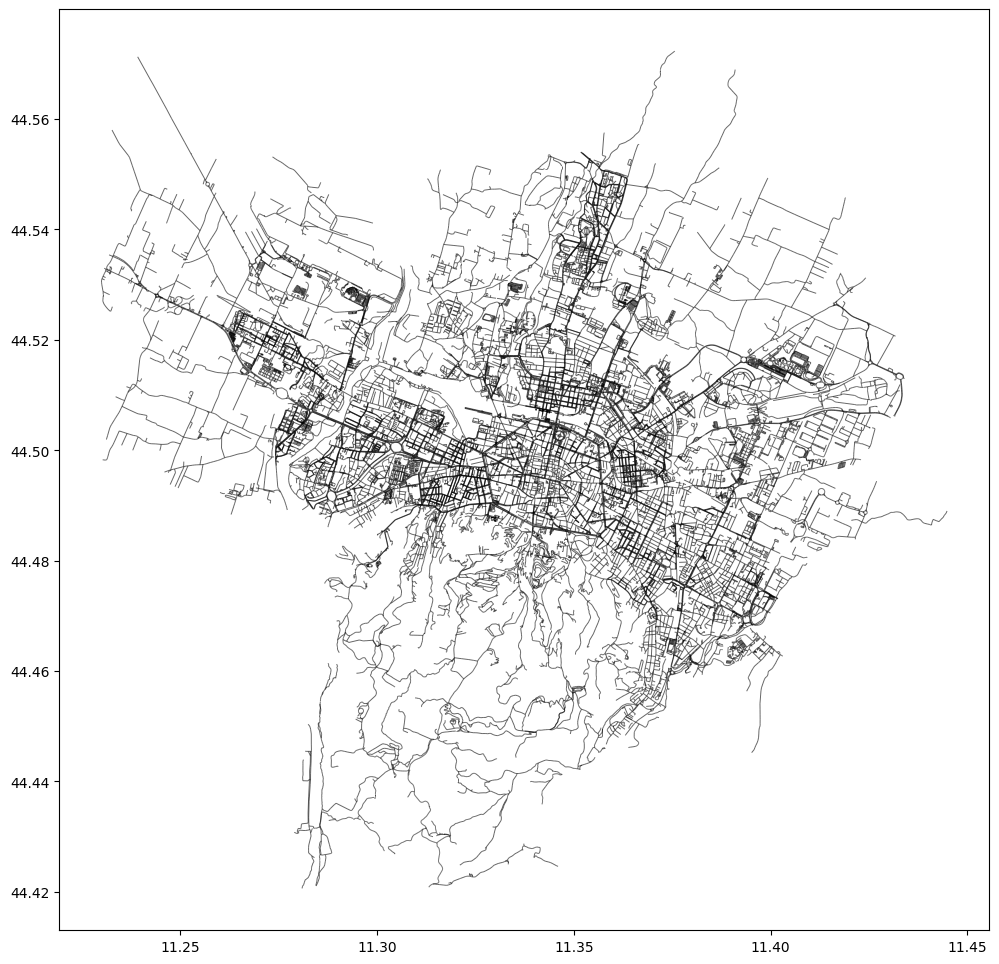

In [5]:
# Walkability
walk = osm.get_network("walking")
walk.plot(color="k", figsize=(12,12), lw=0.7, alpha=0.6)
plt.show()

In [ ]:
# save the file
walk.to_file("D:/Climate_Shelter_Index/isocrona/walk_bologna/walk_bologna.shp")

In [6]:
walk_gdf = gpd.read_file("D:/Climate_Shelter_Index/isocrona/walk_bologna/walk_bologna.shp")

In [7]:
# Perform the intersection between parks and walk
intersection = gpd.overlay(walk_gdf, green_areas, how="intersection")

In [10]:
intersection = intersection.to_crs(epsg=4326)

In [12]:
# Create a new GeoDataFrame with desired columns
result_gdf = gpd.GeoDataFrame(columns=["nome", "bicycle", "highway", "geometry"], crs="epsg:4326")


In [ ]:
# Populate the new GeoDataFrame with data from the intersection
result_gdf["nome"] = intersection["nome"]  
result_gdf['bicycle'] = intersection['bicycle']
result_gdf['highway'] = intersection['highway']
result_gdf["geometry"] = intersection["geometry"].centroid

In [15]:
result_gdf.head(3)

,nome,bicycle,highway,geometry
0,G.NO PADRE GIOVANNI BREVI,designated,cycleway,POINT (11.36948 44.49722)
1,G.NO PADRE GIOVANNI BREVI,NaN,footway,POINT (11.37207 44.49604)
2,G.NO PADRE GIOVANNI BREVI,NaN,footway,POINT (11.37171 44.49571)


In [ ]:
result_gdf.to_file("D:/Climate_Shelter_Index/isocrona/access_green")

### 2. Isochrones
Calculate isochrones for each entrance to the green areas

In [16]:
# Check if GraphHopper is running

# Replace with the actual URL of your GraphHopper server
graphhopper_url = "http://localhost:8989"  # Change the URL as needed

try:
    # Send a GET request to the server's root URL
    response = requests.get(graphhopper_url)

    # Check the status code of the response
    if response.status_code == 200:
        print("GraphHopper is up and running.")
    else:
        print(f"GraphHopper returned a status code {response.status_code}.")
except requests.ConnectionError:
    print("Unable to connect to GraphHopper. Please check if it's running.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

GraphHopper is up and running.


In [42]:
# Set the URL of the GraphHopper server
graphhopper_url = "http://localhost:8989/isochrone"

# Load the shapefile containing points (entrances of green areas)
points_shapefile = "D:/Climate_Shelter_Index/isocrona/access_green/access_green.shp"
# Load the shapefile as a GeoDataFrame
points_gdf = gpd.read_file(points_shapefile)

In [43]:
points_gdf.head(2)

,nome,bicycle,highway,geometry
0,G.NO PADRE GIOVANNI BREVI,designated,cycleway,POINT (11.36948 44.49722)
1,G.NO PADRE GIOVANNI BREVI,NaN,footway,POINT (11.37207 44.49604)


In [44]:
# Initialize an empty GeoDataFrame to store isochrone results
isochrone_gdf = gpd.GeoDataFrame(columns=["green_area_name", "minutes_distance", "geometry"], crs="epsg:4326")

# Iterate through each point in the GeoDataFrame
for index, point in points_gdf.iterrows():
    # Extract latitude and longitude from the point geometry
    lat, lon = point.geometry.y, point.geometry.x

    # Define the isochrone query parameters
    minutes_distance = 5
    timeseconds = str(minutes_distance * 60)
    query = {
        "point": f"{lat},{lon}",
        "time_limit": timeseconds,
        "distance_limit": "0",
        "profile": "foot",
        "buckets": "1",
        "reverse_flow": "false"
    }

    # Send a GET request to the GraphHopper server
    response = requests.get(graphhopper_url, params=query)
    data = response.json()

    # Extract the green area name from the 'nome' column
    green_area_name = point['nome']

    # Extract the isochrone geometry and create a Polygon
    geotype = data['polygons'][0]['geometry']['type']
    geometry = None
    if geotype == "Polygon":
        geometry = Polygon(data['polygons'][0]['geometry']['coordinates'][0])

    # Create a temporary DataFrame
    temp_df = pd.DataFrame({
        "green_area_name": [green_area_name],
        "minutes_distance": [minutes_distance],
        "geometry": [geometry]
    })

    # Append the temporary DataFrame to the isochrone GeoDataFrame
    isochrone_gdf = pd.concat([isochrone_gdf, temp_df], ignore_index=True)

In [45]:
# Convert the concatenated DataFrame back to a GeoDataFrame
isochrone_gdf = gpd.GeoDataFrame(isochrone_gdf)

In [46]:
# Set the CRS for the isochrone GeoDataFrame to EPSG 4326
isochrone_gdf.crs = "epsg:4326"


In [47]:
# Rename columns
isochrone_gdf = isochrone_gdf.rename(columns= {'green_area_name':'ga_name',
                                               'minutes_distance': 'min_dist' })

In [48]:
isochrone_gdf.head()

,ga_name,min_dist,geometry
0,G.NO PADRE GIOVANNI BREVI,5,"POLYGON ((11.36869 44.49648, 11.36868 44.49650..."
1,G.NO PADRE GIOVANNI BREVI,5,"POLYGON ((11.37543 44.49606, 11.37525 44.49594..."
2,G.NO PADRE GIOVANNI BREVI,5,"POLYGON ((11.36904 44.49377, 11.36912 44.49379..."
3,G.NO PADRE GIOVANNI BREVI,5,"POLYGON ((11.37444 44.49604, 11.37435 44.49627..."
4,G.NO PADRE GIOVANNI BREVI,5,"POLYGON ((11.37543 44.49606, 11.37525 44.49594..."


In [68]:
# Aggregate points based on the 'nome' column
aggregated_gdf = isochrone_gdf.dissolve(by='ga_name')

In [71]:
aggregated_gdf = aggregated_gdf.reset_index()

In [72]:
aggregated_gdf.head(3)

,ga_name,geometry,min_dist
0,AIUOLA VIA ALTOBELLI,"POLYGON ((11.28436 44.49720, 11.28393 44.49731...",5
1,AIUOLE DANTI,"POLYGON ((11.30144 44.49374, 11.30132 44.49377...",5
2,AIUOLE RAMENGHI,"POLYGON ((11.30045 44.49442, 11.30009 44.49399...",5


In [73]:
aggregated_gdf.explore()

In [65]:
# Save the isochrone results to a new shapefile
output_shapefile = "D:/Climate_Shelter_Index/isocrona/5min_isochrones.shp"  
isochrone_gdf.to_file(output_shapefile)